In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Lets import all the neccesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('arabic'))

In [3]:
# Read The Data file

df=pd.read_csv('drive/My Drive/Dataset/NewsDataset-New.csv')

In [4]:
df = df[["Title","Category"]]
df

,Title,Category
0,آصف کو لڑائی میں ایک بلا مارا تھا جو اسے دو م...,Sports
1,ایونٹ کے دوران کورونا پھیلا تو پی ایس ایل 7 رو...,Sports
2,پاکستان: کورونا سے 2 اموات، مزید 1400 سے زائد ...,Health
3,اومی کرون سے بچاؤ کی ویکسین مارچ تک متعارف کر...,Health
4,کرائسٹ چرچ ٹیسٹ میں نیوزی لینڈ کامیاب، سیریز ا...,Sports
...,...,...
10811,ایبولا وائرس کی ویکسین تیار,Health
10812,فضائی آلودگی کے پاکستان کی زراعت پر اثرات,Health
10813,دھوپ بیماریوں سے لڑنے والے دفاعی نظام کیلیے بھ...,Health
10814,بلوچستان کے مختلف اضلاع میں خسرہ کی وبا سے 9 ب...,Health


In [5]:
df['Category'].value_counts()

Entertainment           1630
World                   1619
Health                  1590
Business & Economics    1528
Politics                1500
Sports                  1499
Technology              1450
Name: Category, dtype: int64

In [6]:
df['Title'][987]

'ایف بی آر نے پی آئی اے کے اکاؤنٹس ایک بار پھر منجمدکر دیے'

In [7]:
df.isna().sum()

Title       9
Category    0
dtype: int64

In [8]:
# Dropping empty rows
df = df.dropna()

In [9]:
df.isna().sum()

Title       0
Category    0
dtype: int64

In [10]:
# Cleaning the text
space = re.compile('[/(){}\[\]\n|@,;]')
urdu_punctuations = re.compile('[:؛؟’‘٭ء،۔]')
english_punctuations = re.compile('[!"#$%&-./:;<=>?@[\]^_`{|}~]')
english_numbers = re.compile('[0-9]')
english_characters = re.compile('[a-z]')
english_bigcharacters = re.compile('[A-Z]')
STOPWORDS = set(stopwords.words('arabic'))

def clean_text(text):
    text = text.lower() 
    text = space.sub(' ', text)
    text = urdu_punctuations.sub('',text)
    text = english_punctuations.sub('',text)
    text = english_numbers.sub('',text)
    text = english_characters.sub('',text)
    text = english_bigcharacters.sub('',text)
    text = text.replace('x', '')

    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

In [11]:
df['Title']=df['Title'].apply(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df['Title'][100]

'رضوان نے میتھیو ہیڈن کو قرآن شریف تحفے میں دینے کی وجہ بتادی'

In [13]:
g=[]
for i in df['Title']:
    g.append(i)

In [14]:
len(g)

10807

In [15]:
len(g[4])

60

In [16]:
maxl=max([len(s) for s in g])

In [17]:
maxl

397

In [18]:
import pickle
import io
import json

tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Title'].values)
# saving
# with open('tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
# tokenizer_json = tokenizer.to_json()
word_index = tokenizer.word_index
print('Found %s unique tokens.' % word_index)

Found {'کے': 1, 'کی': 2, 'میں': 3, 'کا': 4, 'سے': 5, 'پر': 6, 'کو': 7, 'نے': 8, 'ہے': 9, 'اور': 10, 'کرنے': 11, 'پاکستان': 12, 'ایک': 13, 'ہیں': 14, 'پی': 15, 'کورونا': 16, 'کیلئے': 17, 'بھی': 18, 'کر': 19, 'لیے': 20, 'نہیں': 21, 'کیا': 22, 'ایس': 23, 'کہ': 24, 'یوکرین': 25, 'سی': 26, 'گیا': 27, 'دیا': 28, 'اس': 29, 'ایل': 30, 'خان': 31, 'سال': 32, 'روس': 33, 'فون': 34, 'والے': 35, 'تک': 36, 'متعارف': 37, 'اعلان': 38, 'ہونے': 39, 'فیصلہ': 40, 'خلاف': 41, 'گئی': 42, 'روپے': 43, 'فیصد': 44, 'حکومت': 45, 'ٹی': 46, 'بی': 47, 'ایف': 48, 'ملک': 49, 'نہ': 50, 'کراچی': 51, 'یہ': 52, 'والی': 53, 'دی': 54, 'امریکی': 55, 'ساتھ': 56, 'وائرس': 57, 'وہ': 58, 'اضافہ': 59, 'کمی': 60, 'افراد': 61, 'والا': 62, 'تیار': 63, 'دنیا': 64, 'کم': 65, 'کردیا': 66, 'اب': 67, 'تو': 68, 'ٹیسٹ': 69, 'صدر': 70, 'بھارت': 71, 'ہو': 72, 'بھارتی': 73, 'ان': 74, 'گئے': 75, 'گے': 76, 'اے': 77, 'تھا': 78, 'پاکستانی': 79, 'ایم': 80, 'گا': 81, 'روسی': 82, 'وزیراعظم': 83, 'عالمی': 84, 'ارب': 85, 'فیس': 86, 'سب': 87, 'دے': 88,

In [19]:
X=tokenizer.texts_to_sequences(df['Title'].values)

In [20]:
X=pad_sequences(X,maxlen=250)

In [21]:
X.shape

(10807, 250)

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df["Category"].to_numpy())
class_names = label_encoder.classes_
class_names

array(['Business & Economics', 'Entertainment', 'Health', 'Politics',
       'Sports', 'Technology', 'World'], dtype=object)

In [23]:
Y=pd.get_dummies(df['Category'],columns=df['Category'])

In [24]:
Y

,Business & Economics,Entertainment,Health,Politics,Sports,Technology,World
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
10811,0,0,1,0,0,0,0
10812,0,0,1,0,0,0,0
10813,0,0,1,0,0,0,0
10814,0,0,1,0,0,0,0


In [25]:
len(Y)

10807

In [26]:
df.head()

,Title,Category
0,آصف کو لڑائی میں ایک بلا مارا تھا جو اسے دو م...,Sports
1,ایونٹ کے دوران کورونا پھیلا تو پی ایس ایل روز ...,Sports
2,پاکستان کورونا سے اموات مزید سے زائد کیسز رپورٹ,Health
3,اومی کرون سے بچاؤ کی ویکسین مارچ تک متعارف کرا...,Health
4,کرائسٹ چرچ ٹیسٹ میں نیوزی لینڈ کامیاب سیریز ای...,Sports


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)


In [28]:
X_train

array([[   0,    0,    0, ...,    7,  370,  262],
       [   0,    0,    0, ...,  402,    2,  886],
       [   0,    0,    0, ..., 2393,  499,    9],
       ...,
       [   0,    0,    0, ...,  773,  646,  827],
       [   0,    0,    0, ...,   18,  669, 7205],
       [   0,    0,    0, ..., 2001,  450,  125]], dtype=int32)

In [29]:
y_train

,Business & Economics,Entertainment,Health,Politics,Sports,Technology,World
9397,0,0,0,1,0,0,0
3160,0,0,0,0,0,1,0
9975,0,0,1,0,0,0,0
2213,1,0,0,0,0,0,0
833,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
5734,0,0,0,0,1,0,0
5191,0,1,0,0,0,0,0
5390,0,1,0,0,0,0,0
860,0,1,0,0,0,0,0


In [30]:
# Making LSTM model and then compiling it using Keras Sequential API
model=Sequential()
model.add(Embedding(50000,128,input_length=250))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 128)          6400000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 250, 128)          131584    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 250, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 7)                 9

In [32]:
history = model.fit(X_train, y_train, epochs=7, batch_size=64,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/7
114/114 [==============================] - 394s 3s/step - loss: 1.5014 - accuracy: 0.4240 - val_loss: 0.7931 - val_accuracy: 0.7645
Epoch 2/7
114/114 [==============================] - 379s 3s/step - loss: 0.5914 - accuracy: 0.8135 - val_loss: 0.5831 - val_accuracy: 0.8101
Epoch 3/7
114/114 [==============================] - 396s 3s/step - loss: 0.2809 - accuracy: 0.9182 - val_loss: 0.5641 - val_accuracy: 0.8397
Epoch 4/7
114/114 [==============================] - 382s 3s/step - loss: 0.1543 - accuracy: 0.9572 - val_loss: 0.5734 - val_accuracy: 0.8274
Epoch 5/7
114/114 [==============================] - 384s 3s/step - loss: 0.0961 - accuracy: 0.9742 - val_loss: 0.6345 - val_accuracy: 0.8249
Epoch 6/7
114/114 [==============================] - 376s 3s/step - loss: 0.0663 - accuracy: 0.9829 - val_loss: 0.6601 - val_accuracy: 0.8274


### Saving a model

In [33]:
model.save('drive/My Drive/NewsModelNewsCrawler-FinalTrained')

INFO:tensorflow:Assets written to: drive/My Drive/NewsModelNewsCrawler-FinalTrained/assets


### Loading the trained model

In [34]:
from tensorflow import keras
loaded_model = keras.models.load_model('drive/MyDrive/NewsModelNewsCrawler-FinalTrained')

In [35]:
accr = loaded_model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

85/85 [==============================] - 16s 184ms/step - loss: 0.7414 - accuracy: 0.8194
Test set
  Loss: 0.741
  Accuracy: 0.819


In [36]:
loaded_model_pred_probs = loaded_model.predict(X_test)

In [37]:
import tensorflow as tf
model_1_preds = tf.squeeze(tf.round(loaded_model_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20, 7), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [38]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a multi-class classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [39]:
# Calculate model_1 metrics
model_results = calculate_results(y_true=y_test, 
                                    y_pred=model_1_preds)
model_results

{'accuracy': 81.12509252405626,
 'f1': 0.8250466584098463,
 'precision': 0.8401454390238421,
 'recall': 0.8112509252405625}

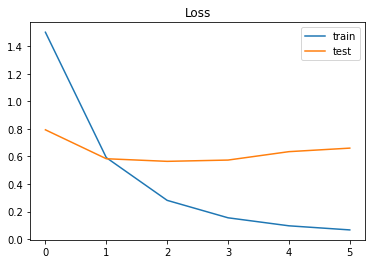

In [40]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

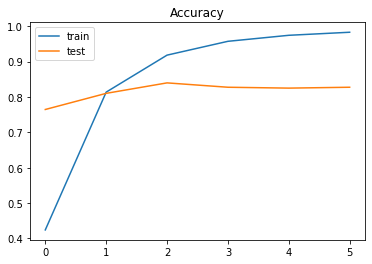

In [41]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [42]:
Y

,Business & Economics,Entertainment,Health,Politics,Sports,Technology,World
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
10811,0,0,1,0,0,0,0
10812,0,0,1,0,0,0,0
10813,0,0,1,0,0,0,0
10814,0,0,1,0,0,0,0


In [43]:
labels = Y.columns.tolist()
labels

['Business & Economics',
 'Entertainment',
 'Health',
 'Politics',
 'Sports',
 'Technology',
 'World']

In [44]:
# new_complaint = ['لڑاکا ڈرون جو مستقبل کی جنگوں کی نوعیت کو ہمیشہ کے لیے بدل رہے']
news_title = "کنیئرڈ کالج یونیورسٹی میں منعقد کیے گئے کنسرٹ میں عاظم اظہر کو بھی پرفارمنس کرنی تھی مگر انہوں نے نہیں کی۔"
news_title = clean_text(news_title)
news_title

'کنیئرڈ کالج یونیورسٹی میں منعقد کیے گئے کنسرٹ میں عاظم اظہر کو بھی پرفارمنس کرنی تھی مگر انہوں نے نہیں کی'

In [45]:
# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = keras.preprocessing.text.tokenizer_from_json(data)
seq = tokenizer.texts_to_sequences([news_title])
print(seq)
padded = pad_sequences(seq, maxlen=250)
print(padded)
pred = loaded_model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[2461, 1203, 3, 1369, 269, 75, 3161, 3, 995, 7, 18, 2362, 2242, 199, 444, 2893, 8, 21, 2]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   

In [46]:
df["Category"].value_counts()

Entertainment           1630
World                   1619
Health                  1590
Business & Economics    1528
Politics                1500
Sports                  1499
Technology              1441
Name: Category, dtype: int64

In [47]:
def model_prediction(text):
  text = clean_text(text)
  # # loading
  # with open('tokenizer.pickle', 'rb') as handle:
  #   tokenizer = pickle.load(handle)
  with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = keras.preprocessing.text.tokenizer_from_json(data)
  seq = tokenizer.texts_to_sequences([text])
  padded = pad_sequences(seq, maxlen=250)
  pred = loaded_model.predict(padded)
  return labels[np.argmax(pred)]

In [48]:
model_prediction("راولپنڈی ٹیسٹ کا چوتھا روز: عثمان خواجہ تین رنز سے تو آج لبوشین کی سنچری 10 رنز سے رہ گئی")

'Sports'

In [49]:
model_prediction("’تیری راہ میں‘: ‘ایمان جیسی بہو ہر ساس چاہتی ہے‘")

'Entertainment'

In [50]:
model_prediction("امریکی ماڈل کا فلسطین کے لیے امداد کا اعلان فیشن میگزین پر تنقید کا باعث کیسے بنا")

'Entertainment'

In [51]:
model_prediction("بارہواں کھلاڑی: 'ہمیں لگتا تھا کہ ہم بوڑھے اور ماہرہ خان زیادہ جوان ہیں‘")

'Entertainment'

In [52]:
model_prediction("شے گل ’پسوڑی‘ گانے کی ریلیز اور اس پر عوامی ردعمل پر بات کرتے ہوئے کہتی ہیں کہ ’بہت اچھا محسوس کر رہی ہوں، جب گانے پر کام کرنا شروع کیا تھا تو اندازہ تھا کہ یہ لوگوں کو پسند آئے گا۔ لیکن مجھے یہ نہیں پتا تھا کہ لوگوں کو میں بھی اتنی پسند آؤں گی۔‘")

'Sports'

In [53]:
model_prediction("’پشپا‘ کے 14 دن میں 234 کروڑ، جنوبی انڈین فلمیں اتنی مقبول کیوں ہیں؟")

'Entertainment'

In [54]:
model_prediction("2024 کے انتخابات سے قبل یہ بھارتی وزیر اعظم نریندر مودی کی ہندو قوم پرست بھارتیہ جنتا پارٹی کے لیے ایک اہم امتحان ہے۔")

'World'

In [55]:
model_prediction("صیہونی ریاست اور مسئلہ فلسطین کے حل کے حامی ترکی کے درمیان دوطرفہ معاملات پر زیادہ بات چیت کا امکان ہے۔")

'World'

In [56]:
model_prediction("آئین کے تحت کسی کو پرائیویٹ ملیشیا رکھنے کی اجازت نہیں، قانون ہاتھ میں لیا تو قانون آپ کو ہاتھ میں لے گا، شیخ رشید احمد")

'Entertainment'

In [57]:
model_prediction("جو لوگ مداخلت کی بات کرتے ہیں،اس کا جواب بھی انہی سے مانگا جائے، اگر کوئی بات کرتا ہے تو اس کے پاس ثبوت بھی ہوں گے،آئی ایس پی آر")

'Entertainment'

In [58]:
model_prediction("جے یو آئی(ف) کے رکن اسمبلی صلاح الدین ایوبی کو گرفتار کر لیا گیا، ڈی چوک اور پارلیمنٹ لاجز میں موجود افسران کو معطل کردیا گیا۔")

'World'

In [59]:
model_prediction("سوشل میڈیا نیٹ ورکس کے بعد اب ٹک ٹاک میوزک پلیٹ فارمز جیسے اسپاٹی فائے، ایپل میوزک اور پنڈورا کو بھی ٹکر دینے کے لیے تیار ہے۔")

'Entertainment'

In [60]:
model_prediction("رئیل می 9 سیریز کے 2 نئے فونز متعارف")

'Technology'

In [61]:
model_prediction("رئیل می 9 سیریز کے 2 نئے فونز متعارف")

'Technology'

In [62]:
model_prediction("امریکی پابندیوں کے باعث فون میں گوگل سروسز موجود نہیں بلکہ ہواوے ایپ گیلری اسٹور متبادل کے طور پر موجود ہے۔")

'Technology'

In [63]:
model_prediction("خنزیر کے دل کی پیوندکاری کروانے والا شخص دو ماہ بعد چل بسا")

'Health'

In [64]:
model_prediction("یونیورسٹی آف میری لینڈ میڈیکل سینٹر (UMMC) نے بتایا کہ عارضۂ  قلب میں مبتلا 57 سالہ ڈیوڈ جنہوں نے جینیاتی طور پر تبدیل شدہ خنزیر کے دل کا ٹرانسپلانٹ کروایا تھا منگل کی سہ پہر انتقال کرگئے ہیں۔")

'World'

In [65]:
model_prediction("عورت مارچ خواتین کی مدد نہیں صرف تنازعات کو ہوا دیتا ہے، وینا ملک ")

'Entertainment'

In [66]:
model_prediction("سلمان خان کا مدر ٹریسا کو خراج تحسین ")

'Entertainment'

In [67]:
model_prediction("جو عمران خان کے ساتھ کھڑا ہوگا، اللہ بھی اسے عزت دے گا، قوم بھی، شیخ رشید")

'Politics'

In [68]:
model_prediction("شعیب ملک بھی ثنا جاوید کے معاملے میں کُود پڑے")

'Entertainment'

In [69]:
model_prediction("میسجنگ ایپ ٹیلیگرام میں متعدد اہم تبدیلیاں متعارف")

'Technology'

In [70]:
model_prediction("واٹس ایپ کا پیغامات فارورڈ کرنے پر مزید پابندیاں عائد کرنے کا فیصلہ")

'Technology'

In [71]:
model_prediction("آئی ایم ایف نے غیر اہدافی سبسڈی، ایمنسٹی اسکیم پر سوالات اٹھادیے")

'Business & Economics'

In [72]:
model_prediction("گاڑیوں کی فروخت میں 57 فیصد اضافہ‘")

'Business & Economics'

In [73]:
model_prediction("عالمی منڈی میں خام تیل کی قیمت میں 12 فیصد کمی")

'Business & Economics'

In [74]:
model_prediction("کراچی ٹیسٹ کا پہلا دن آسٹریلیا کے نام، 3 وکٹوں پر 251رنز بنا لیے")

'Sports'

In [75]:
model_prediction("16 سالہ احسن رمضان کم عمر ترین ورلڈ اسنوکر چیمپیئن بن گئے")

'Sports'

In [76]:
model_prediction("شین وارن، عبدالقادر کا گھر اور ’کینو‘ کے ساتھ گوگلی کا دلچسپ واقعہ")

'Sports'

In [77]:
model_prediction("29 اقسام کے جانوروں میں کووڈ کیسز دریافت")

'World'

In [78]:
model_prediction("مریضوں میں کووڈ کی شدت بڑھانے والے 16 جینز کی دریافت")

'Health'

In [79]:
model_prediction("فیس ماسک کووڈ سے بچانے میں اہم کردار ادا کرتے ہیں، تحقیق")

'Technology'

In [80]:
model_prediction("ایمازون جنگلات کے قبائلی باشندوں میں ڈیمینشیا کی سب سے کم ترین شرح")

'Business & Economics'

In [81]:
model_prediction("خنزیر کے دل کی پیوندکاری کروانے والا شخص دو ماہ بعد چل بسا ")

'Health'

In [82]:
model_prediction("روس کا یوکرین کے سب سے بڑے فوجی اڈے پر حملہ؛ 35 ہلاک اور 134 زخمی")

'World'